# (00) Clasificación de ingresos
Este es el primer notebook, en el que haremos la descripción del proyecto, profundizaremos en el dataset y haremos un anáisis inicial
aclarar preguntas que se resolverán a lo largo del proyecto, modelo a aplicar y el objetivo

entorno: eda (anaconda)


### Respecto al dataset que estaremos utilizando:
Proviene de un estudio realizado con el *Census Bureau* de EEUU. Contiene información de elementos demográfciso y económicos de personas.
* **Objetivo principal**: A partir de datos personales y laborales de los sujetos de estudio. Predecir si una persona tiene o no tiene un ingreso superior a USD $50,000 anuales 

El dataset contiene un total de $48,842$ ocurrencias *($48,813$ si eliminamos elementos duplicados)*, de las cuales algunas contienen valores desconocidos. Antes del análisis exploratorio, comenzaremos analizando los valores faltantes, si los hay, cómo ingluyen a los demás elementos y de qué tipo son.

### dataset facts:
El dataset ah sido utilizado ampliamente en estudios de clasificación binaria, con la variable `income` que indica si una persona tiene o un ingreso mayor o menor a 50k anuales

### Columnas del dataset:
(*"$n$ tipos distintos"* equivale al número de elementos/categorías diferentes que hay en cada columna **categórica**): 
* **age**: edad del sujeto
* **workclass**: Tipo de trabajo / sector al que pertenece el individuo *(gobierno, privado, sin empleo, etc.)* . $9$ tipos distintos
* **fnlwgt**: Peso final del individup en la encuesta (descripción de esta variable más abajo) 
* **education_num**: Nivel educativo del individuo *(en formato numérico)* correspondiente a los años de educación completados
* **marital_status**: Estado civil del individuo *(soltero, casado)*
* **occupation**: A qué se dedica *(ejecutivo, obrero, empleado de gobierno, etc)* . $15$ tipos distintos
* **relationship**: Rol **familiar** que el individuo asume dentro del hogar *(jefe de hogar, esposo/a)*. $6$ tipos distintos
* **ethnicity**: Etnia del individuo *(Blanco, negro, asiático)*. $5$ tipos distintos
* **genre**: género del individuo. $2$ tipos distintos
* **capital_gain**: Ganancias de vapital adicionales, fuera del salario o ingresos laborales
* **capital_loss**: Pérdidas de capital adicionales
* **hours_per_week**: Horas trabajadas por semana
* **native_country**: País de origen del indiviuo
* **income**: Variable objetivo.
    * no $=$ salario USD$<= 50k$ anuales **(individuo gana 50k anuales o menos)**
    * yes  $=$ salario USD$> 50k$ anuales **(individuo gana más de 50k anuales)**

#### Explicación de la columna `fnlwgt` (peso final):
Es un concepto relacionado con encuestas y estudios demográficos realizados por *Census Bureau*. Su propósito es ajustar la muestra para que sea representativa de la población total de EEUU. Este proceso permite que los resultados de la encuesta sean más precisos al inferir información sobre la población completa.

No todos los sujetos en la encuesta representan a la misma cantidad de personas en la población. Por lo tanto, con esta variable asignamos un peso a cada registro para reflejar cuántas personas en la población están representadas por esa persona en la muestra.

`fnlwgt` se calcula utilizando una serie de cotnroles relacionados con la edad, género, étnia, origen hispano, entre otros factores. Esencialmente, asegura que la muestra sea representatica y que los resultados puedan ser generalizados a la población total.

Ejemplo: Dada una persona de California *(con sus respectivos datos demográficos y económicos)* tiene un `fnlwgt = 1000` significa que este sujeto representa a 1k personas con características similares en la población general.



#### importación de librerías, módulos y dataset

In [1]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from typing import List

In [2]:
# own modules
from import_modules import import_to_nb
import_to_nb(directory= 'scripts', show_content= False)
import_to_nb(directory= 'modules', show_content= False)

#-# directory: scripts
from load_data import Loader
from utils     import Utils
from utils_missing_extension_plots import MissingPlotMethods
from utils_missing_extension       import MissingMethods
from utils_initial_exploration     import InitialExploration
from utils_categorical_plots       import CategoricalPlots
from utils_classif_models_plots    import ClassifModelsPlots
from utils_probability_funcs       import ProbabilityFuncs

#-# directory: modules
from list_and_dicts import ListAndDicts

In [3]:
load          = Loader()
utils         = Utils()
initial_exp   = InitialExploration()
cat_plots     = CategoricalPlots()
classif_plots = ClassifModelsPlots()
prob          = ProbabilityFuncs()
list_dicts    = ListAndDicts()

In [4]:
# load appereance
utils.load_appereance()

fusionar datasets (validación y test) porque comenzaremos desde 0

In [5]:
# carga de dataset
df_raw_test       = load.load_data(file_name='adult.csv',
                                   dir= 'raw', header= None)
df_raw_validation = load.load_data(file_name='adult_val',
                                   dir= 'raw', header= None)

# fusionamos ambos dataframes
df_raw_complete = pd.concat([df_raw_test, df_raw_validation],
                   ignore_index = True)

cols = list_dicts.initial_name_cols # nombres (originales) de cols

# corroborar que hayan los mismos elementos en el df resultado
df_raw_test.columns       = cols        
df_raw_validation.columns = cols
df_raw_complete.columns   = cols

In [6]:
df_raw_complete.shape[0] == df_raw_test.shape[0] + df_raw_validation.shape[0]

True

In [7]:
#load.save_dataframe(df= df_raw_complete, file_name= 'adult_complete', dir= 'raw')

In [8]:
df_raw = load.load_data(file_name= 'adult_complete', dir= 'raw')

#### comienzo del análisis  

### Limpieza inicial

Los nombres de las variables y sus categorías tienen espacios, mayúsculas, guiones, etc
* se cambiarán los nombres para que el análisis sea más sencillo de entender

In [9]:
df_drop_duplicates = df_raw.drop_duplicates(inplace= True)         # sacar duplicados
df_raw.columns = [col.replace('-', '_') for col in df_raw.columns] # sacar guiones de nombres
df_raw.rename(columns= {'race': 'ethnicity', 'sex': 'genre'},      # renombrar cols
              inplace= True)

#-#-# categóricas              
df_raw.income = df_raw.income.apply(                                
                lambda x: 'yes' if x == ' >50K' or x == ' >50K.' else 'no')

# sacar espacios iniciales -> " nombre-categoría"
object_cols = df_raw.select_dtypes(include= 'object').columns

for col in object_cols:
    df_raw[col] = df_raw[col].apply(lambda x: x.strip())

#cambiar nombres de categorías (algunos)
iter_cols = list_dicts.replace_iter_cols # diccionario en -> ./extra_modules/list_and_dicts.py

for key, value in iter_cols.items():
    df_raw[key] = df_raw[key].apply(lambda x: value[x] if x in value.keys() else x)

In [10]:
#load.save_dataframe(df= df_raw, file_name= 'adult_clean', dir= 'clean')

In [11]:
df_raw[:3]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,ethnicity,genre,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,state_gov,77516,bachelors,13,never_married,adm_clerical,not_in_family,white,Male,2174,0,40,USA,no
1,50,self_emp_not_inc,83311,bachelors,13,married_civ_spouse,exec_managerial,husband,white,Male,0,0,13,USA,no
2,38,Private,215646,hs_grad,9,divorced,handlers_cleaners,not_in_family,white,Male,0,0,40,USA,no


In [12]:
# relative frequency for income col
df_raw.income.value_counts(normalize= True)

income
no     0.760617
yes    0.239383
Name: proportion, dtype: float64

#### problema:
se ha encontrado un grave desbalanceo de datos en la variable predictora `income`, teniendo: 
* **ocurrencias**: $\approx 11,680$ en *yes* ($\approx 23$ %)
* **ocurrencias**: $\approx 37,097$ en *no* $\space$($\approx 76$ %)

Si se entrena un modelo ignorando esto. Podriamos obtener un modelo que, efectivamente sea capaz de predecir correctamente a casos **NO**, pero muy malo en **YES**

*(este problema se resolverá al terminar el análisis exploratorio)*

En adición, también se ha encotnrado desbalanceo de datos en otras variables de entrenamiento, tales como: 
* genre, ethicity, marital_status, occupation, relationship

* * Sin embargo, **no se tomarán medidas extra para compensar tal desbalanceo**; La razón de esto es para evitar sesgar los datos de entrenamiento. Caso contrario con la predictora, donde sí se tomarán medidas necesarias para contrarrestar el problema

In [13]:
df_raw.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'ethnicity', 'genre',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [14]:
initial_exp.initial_exploration(df= df_raw) # no hay nulos explícitos

,type,not_null_count,null_count,null_percent
age,int64,48813,0,0.0
workclass,object,48813,0,0.0
fnlwgt,int64,48813,0,0.0
education,object,48813,0,0.0
education_num,int64,48813,0,0.0
marital_status,object,48813,0,0.0
occupation,object,48813,0,0.0
relationship,object,48813,0,0.0
ethnicity,object,48813,0,0.0
genre,object,48813,0,0.0


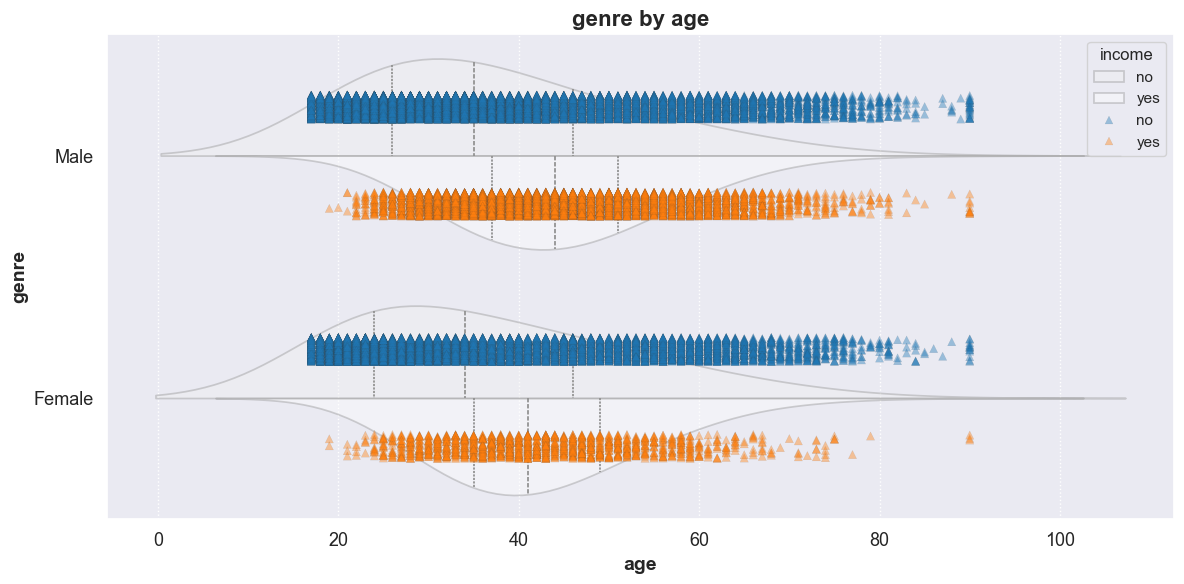

In [15]:
cat_plots.violin_strip(df=df_raw,  x= 'age', y= 'genre', hue= 'income')

### numéricas

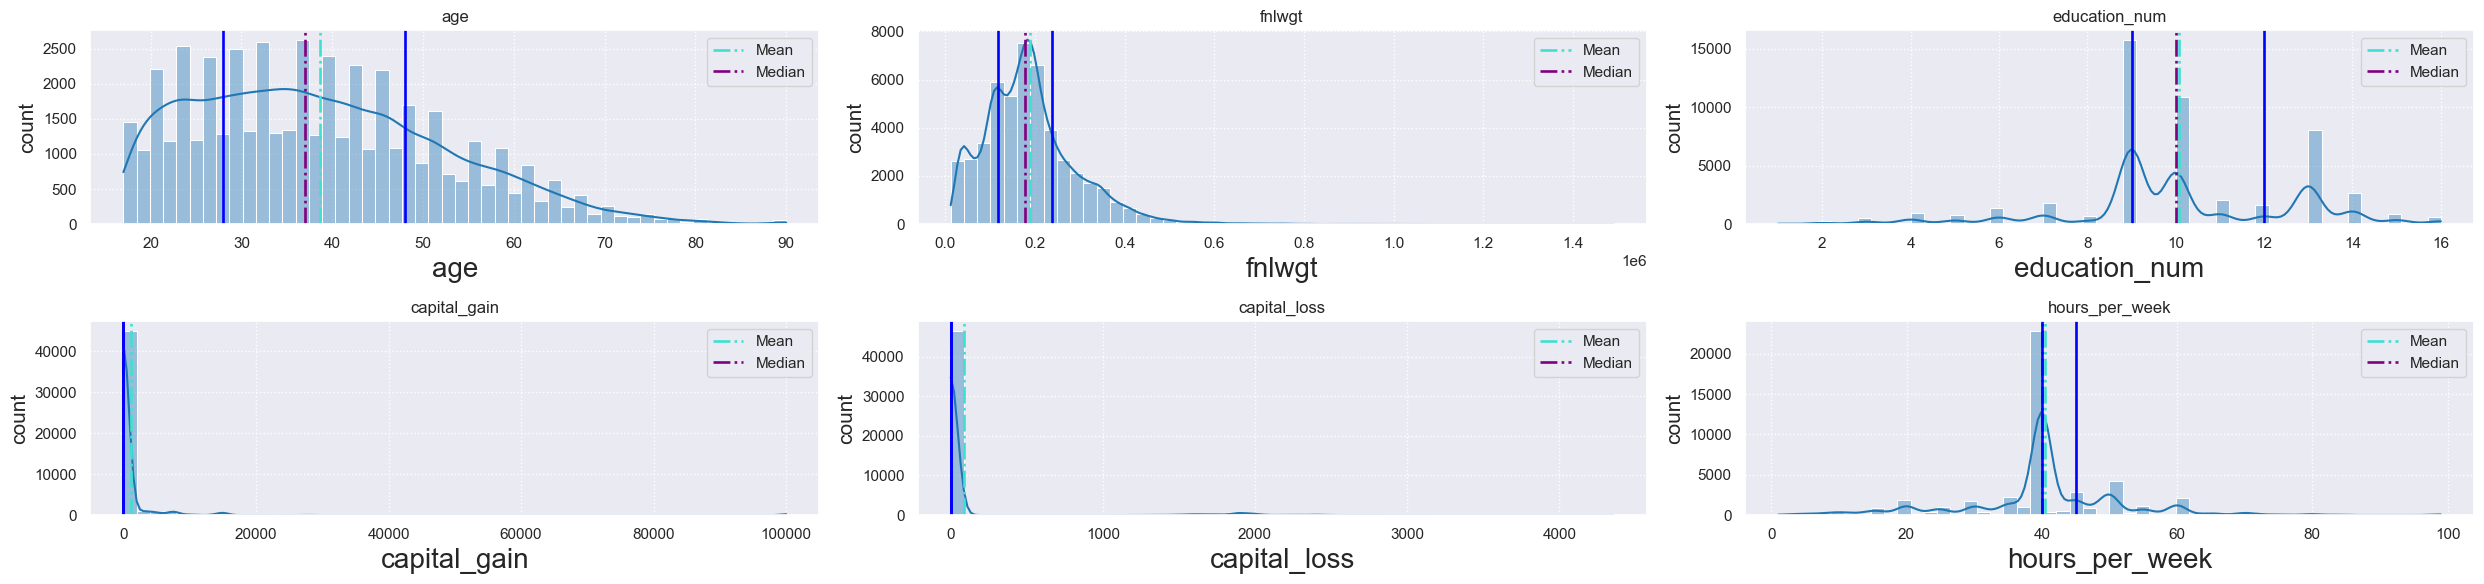

In [16]:
num_cols = df_raw.select_dtypes(include= ['int', 'float']).columns

cat_plots.plot_dist(df = df_raw, cols= num_cols , subplot_list=[2,3],stats= True)

## categóricas

In [17]:
df_cat = df_raw.select_dtypes(include= 'object')
df_cat[:3]

,workclass,education,marital_status,occupation,relationship,ethnicity,genre,native_country,income
0,state_gov,bachelors,never_married,adm_clerical,not_in_family,white,Male,USA,no
1,self_emp_not_inc,bachelors,married_civ_spouse,exec_managerial,husband,white,Male,USA,no
2,Private,hs_grad,divorced,handlers_cleaners,not_in_family,white,Male,USA,no


In [18]:
#df_raw.relationship.unique()

Para observar mejor la estructura de las filas, invocaremos a una de ellas 

In [24]:
# fila 48838
pd.DataFrame(df_raw.loc[48838])

,48838
age,64
workclass,unknown
fnlwgt,321403
education,hs_grad
education_num,9
marital_status,widowed
occupation,unknown
relationship,other_relative
ethnicity,black
genre,Male


**nota**: profundizar en la investigación de los *unknown*.
* ($H_1$) la mayoría de las ocurrencias con elementos "unknown" suceden en sujetos de étnia en su mayoría negra (no blanca)

In [20]:
len(df_cat.columns)

9

In [21]:
df_raw[:3]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,ethnicity,genre,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,state_gov,77516,bachelors,13,never_married,adm_clerical,not_in_family,white,Male,2174,0,40,USA,no
1,50,self_emp_not_inc,83311,bachelors,13,married_civ_spouse,exec_managerial,husband,white,Male,0,0,13,USA,no
2,38,Private,215646,hs_grad,9,divorced,handlers_cleaners,not_in_family,white,Male,0,0,40,USA,no


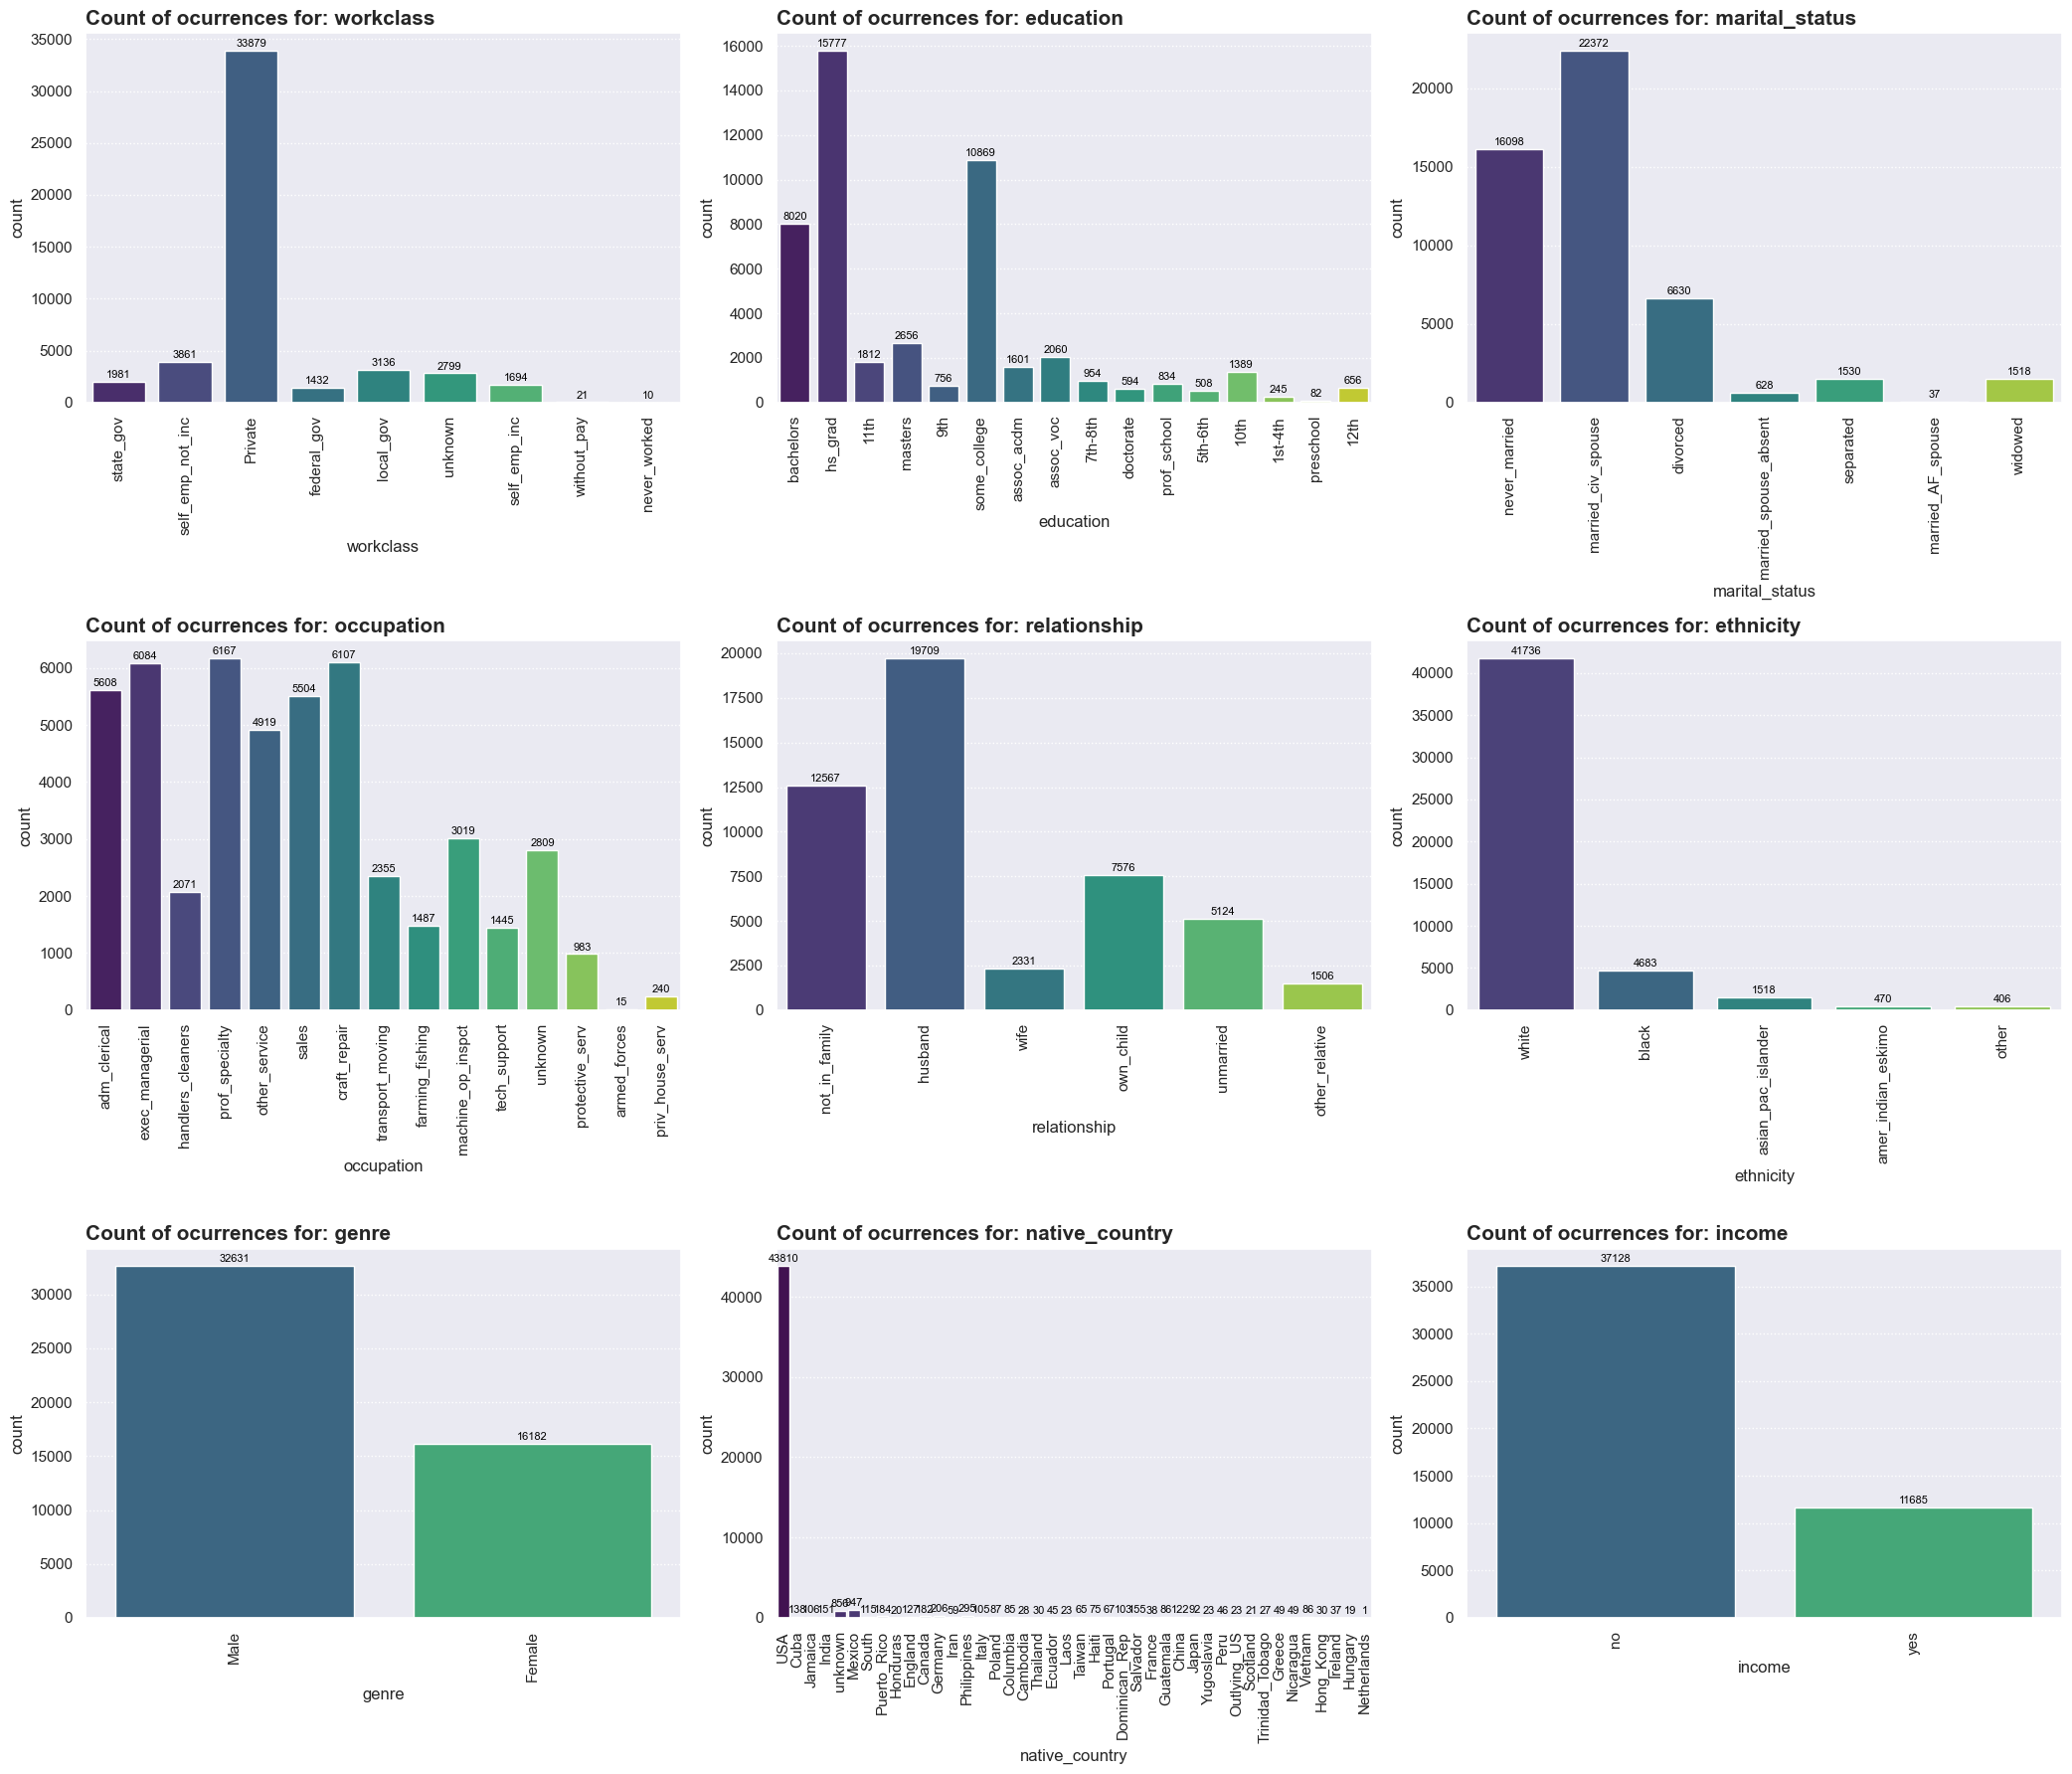

In [22]:
# path: ./scripts/utils_categorical_plots.py
cat_plots.plot_cat_feq(df= df_cat, cols= df_cat.columns, rotation= 90)

### datos 'unknown' 

In [23]:
unknown_data = df_raw[df_raw.isin(['unknown']).any(axis= 1)]
print(f'filas con datos unkown: {unknown_data.shape}')

unknown_data_cols = unknown_data.isin(['unknown']).sum().sort_values(ascending= False)
unknown_data_cols[:4]

filas con datos unkown: (3619, 15)


occupation        2809
workclass         2799
native_country     856
age                  0
dtype: int64

<div class="alert alert-info">
    <b style="font-size: 1.5em;">🔍 valores unknown</b>
    <p>Existen tres columnas que contienen como dato 'unknown':</p> 
    <ul>
        <li><b>occupation</b> (2809): la mayor cantidad </li>
        <li><b>workclass</b> (2799): cantidad significativa</li>
        <li><b>native_country</b> (856): mucho menos 'unknown' comparado a las dos anteriores</li>
    </ul>
    <p>La presencia de datos <i>unknown</i> en estas columnas podría deberse a que:</p>
    <ol>
        <li>Las personas encuestadas no especificaron ocupación/tipo de trabajo/país de origen</li>
        <li>hubo problemas al recolectar esta información</li>
    </ol>
    <p>Será importante <b>NO</b> ignorar a los <i>unknown</i> en el análisis y modelado posterior, ya que pueden afectar la precisión y generalización del modelo.</p>
    <ol>
        <li>Se tratan de <b>valores faltantes implícitos</b> dentro del dataset.</li>
        <li>Por lo que se comenzará a realizar un análisis de datos faltantes de estas columnas, y observar qué tanto afecta su presencia con respecto a las demás <i>(y sobretodo a la predictora: income)</i></li>
    </ol>
    <p><b>NOTA:</b> Se continuará con este proceso en el siguiente notebook</p>
</div>